#1.importing libraries

In [ ]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#printing the stopwords in english language
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

#2.preprocessing


1.framing the data into data frame

In [ ]:
#loading the data from csv file to pandas data frame
twitter_data = pd.read_csv('/content/twitter_training.csv',encoding= 'ISO-8859-1')

In [ ]:
#printing the no of rows and columns
twitter_data.shape

(74681, 4)

In [ ]:
#printing the first five rows
twitter_data.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


2.data managing

In [ ]:
#naming the columns
column_names=['id','flag','target','text']
twitter_data = pd.read_csv('/content/twitter_training.csv', names = column_names, encoding= 'ISO-8859-1')

In [ ]:
twitter_data.shape

(74682, 4)

In [ ]:
twitter_data.head()

,id,flag,target,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [ ]:
#counting the no of missing values
twitter_data.isnull().sum()

,0
id,0
flag,0
target,0
text,686


In [ ]:
twitter_data=twitter_data.dropna()
twitter_data.isna().sum()

,0
id,0
flag,0
target,0
text,0


In [ ]:
#checking the distribution of target column
twitter_data['target'].value_counts()

,count
target,
Negative,22358
Positive,20655
Neutral,18108
Irrelevant,12875


3.stemming


In [ ]:
port_stem = PorterStemmer()

In [ ]:
def preprocess_and_tokenize(content):
    # Removing non-alphabet characters and converting to lowercase
    content = re.sub('[^a-zA-Z]', ' ', content).lower()
    # Splitting and removing stopwords
    tokens = [port_stem.stem(word) for word in content.split() if word not in stopwords.words('english')]
    return tokens

# Tokenize the tweets
twitter_data['tokens'] = twitter_data['text'].apply(preprocess_and_tokenize)



In [ ]:
from sklearn.preprocessing import LabelEncoder
# Assuming your target column is named 'target'
label_encoder = LabelEncoder()
twitter_data['target'] = label_encoder.fit_transform(twitter_data['target'])

# Check the unique values after encoding
print("Encoded classes:", label_encoder.classes_)

Encoded classes: ['Irrelevant' 'Negative' 'Neutral' 'Positive']


In [ ]:
# Separating the data and labels
x = twitter_data['tokens'].values
y = twitter_data['target'].values

In [ ]:
twitter_data.head()

,id,flag,target,text,tokens
0,2401,Borderlands,3,im getting on borderlands and i will murder yo...,"[im, get, borderland, murder]"
1,2401,Borderlands,3,I am coming to the borders and I will kill you...,"[come, border, kill]"
2,2401,Borderlands,3,im getting on borderlands and i will kill you ...,"[im, get, borderland, kill]"
3,2401,Borderlands,3,im coming on borderlands and i will murder you...,"[im, come, borderland, murder]"
4,2401,Borderlands,3,im getting on borderlands 2 and i will murder ...,"[im, get, borderland, murder]"


In [ ]:
print(x)

[list(['im', 'get', 'borderland', 'murder'])
 list(['come', 'border', 'kill'])
 list(['im', 'get', 'borderland', 'kill']) ...
 list(['realiz', 'window', 'partit', 'mac', 'year', 'behind', 'nvidia', 'driver', 'idea', 'notic'])
 list(['realiz', 'window', 'partit', 'mac', 'like', 'year', 'behind', 'nvidia', 'driver', 'car', 'fuck', 'idea', 'ever', 'notic'])
 list(['like', 'window', 'partit', 'mac', 'like', 'year', 'behind', 'driver', 'idea', 'notic'])]


In [ ]:
print(y)

[3 3 3 ... 3 3 3]


#3.Splitting the data into training data and test data



In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,stratify=y,random_state=2)

In [ ]:
print(x.shape,x_train.shape,x_test.shape)

(73996,) (59196,) (14800,)


4.vectorization


In [ ]:
import gensim
from gensim.models import Word2Vec

In [ ]:
#5. Word2Vec Embeddings
# Training Word2Vec model on the training data
w2v_model = Word2Vec(sentences=x_train.tolist(), vector_size=100, window=5, min_count=1, sg=1)

# Function to get the average word vector for each tweet
def get_average_word2vec(tokens, model, vector_size):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(vector_size)

# Creating average word vectors for each tweet in training and test sets
x_train_vec = np.array([get_average_word2vec(tokens, w2v_model, 100) for tokens in x_train])
x_test_vec = np.array([get_average_word2vec(tokens, w2v_model, 100) for tokens in x_test])

# 4.Training the Machine learning model

Logistic Regression

In [ ]:
lr = LogisticRegression()
lr.fit(x_train_vec,y_train)

LogisticRegression()

In [ ]:
x_train_prediction = lr.predict(x_train_vec)
training_data_accuracy = accuracy_score(x_train_prediction,y_train)

In [ ]:
print('Accuracy score of the training data: ',training_data_accuracy*100)

Accuracy score of the training data:  54.1066963984053


In [ ]:
import xgboost as xgb
clf_xgb=xgb.XGBClassifier()
clf_xgb.fit(x_train_vec,y_train)
x_train_prediction_xgb=clf_xgb.predict(x_train_vec)
training_data_accuracy_xgb=accuracy_score(x_train_prediction_xgb,y_train)
print(training_data_accuracy_xgb*100)

89.58713426582877


In [ ]:

from sklearn.ensemble import RandomForestClassifier
#random forest model
rf_model = RandomForestClassifier()
rf_model.fit(x_train_vec, y_train)

RandomForestClassifier()

In [ ]:
x_train_prediction_rf = rf_model.predict(x_train_vec)
accuracy_rf = accuracy_score(y_train, x_train_prediction_rf)
#print(f'Accuracy of Random Forest model: {accuracy_rf:.2f}')
print(accuracy_rf*100)

97.37482262315021


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Assuming x_train_vec is your feature matrix with potential negative values
scaler = MinMaxScaler()
x_train_vec_scaled = scaler.fit_transform(x_train_vec)
x_test_vec_scaled = scaler.transform(x_test_vec)

MN Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
# Now fit the MultinomialNB model
classifier = MultinomialNB()
classifier.fit(x_train_vec_scaled, y_train)

MultinomialNB()

In [ ]:

x_train_prediction_nb = classifier.predict(x_train_vec_scaled)
training_datas_accuracy_nb = accuracy_score(x_train_prediction_nb,y_train)

In [ ]:
print('Accuracy score of the training data: ',training_datas_accuracy_nb*100)

Accuracy score of the training data:  36.289614163119126


In [ ]:
from sklearn.ensemble import VotingClassifier
ensemble_model = VotingClassifier(estimators=[
    ('logistic_regression', lr),
    ('xgboost', clf_xgb),
    ('naive_bayes', classifier),
    ('randomforest', rf_model)
], voting='hard')  # Use 'soft' for probability-based voting

# Train the ensemble model on the training data
ensemble_model.fit(x_train_vec_scaled, y_train)

# Evaluate the ensemble model on training data
y_train_pred_ensemble = ensemble_model.predict(x_train_vec_scaled)
training_accuracy_ensemble = accuracy_score(y_train_pred_ensemble, y_train)
print('Ensemble Model Accuracy on Training Data: ', training_accuracy_ensemble * 100)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Ensemble Model Accuracy on Training Data:  83.58503952969795


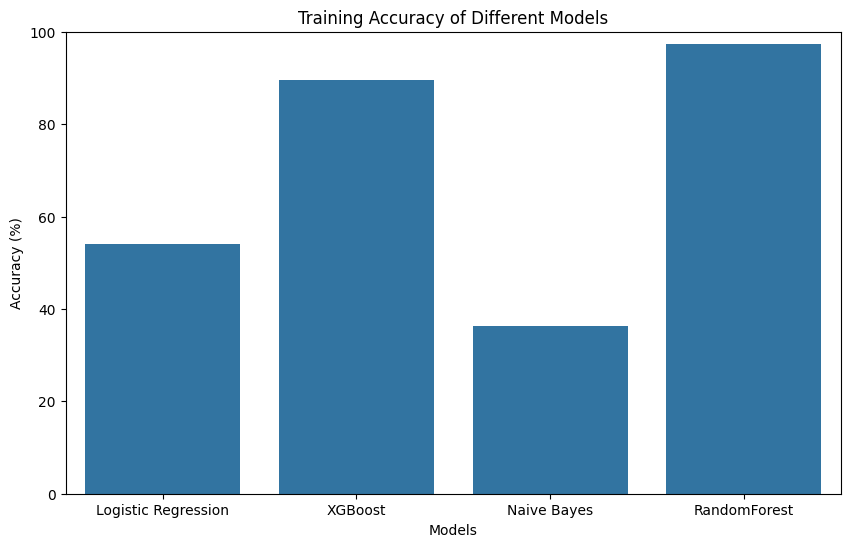

In [ ]:
# Plotting training accuracies

import seaborn as sns
import matplotlib.pyplot as plt

models = ['Logistic Regression', 'XGBoost', 'Naive Bayes', 'RandomForest']
accuracies = [
    training_data_accuracy * 100,
    training_data_accuracy_xgb * 100,
    training_datas_accuracy_nb * 100,
    accuracy_rf * 100
]

plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracies)
plt.title('Training Accuracy of Different Models')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.show()